# Jupyter notebook covid data analysis Tim Hensen

## Importing data

In [7]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import preprocessing
import seaborn as sns; sns.set()

In [8]:
# importing main dataset
df = pd.read_csv("owid_main_agi.csv")

# Raw data inspection
df.head()

# We only need to use the total cases and deaths, so:
df_total = df.loc[df['date'] == '2020-09-11']

In [9]:
#Data inspection
df_total.shape

(211, 17)

In [10]:
df_total.head()

,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
255,Afghanistan,2020-09-11,990.846,36.477,54.422,18.6,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,0.498
443,Albania,2020-09-11,3773.716,112.586,104.871,38.0,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
700,Algeria,2020-09-11,1082.939,36.282,17.348,29.1,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,0.754
889,Andorra,2020-09-11,16838.154,685.951,163.755,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.858
1064,Angola,2020-09-11,94.078,3.834,23.890,16.8,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,NaN,61.15,0.581


In [11]:
# Import extra datasets
dfa = pd.read_csv('asthma_agi.csv')
dfp = pd.read_csv('air_pollution_agi.csv')
dfs = pd.read_csv('smoking.csv')
dfo = pd.read_csv('obesity.csv')

# Select only latest year of measurement
df_at = dfa.loc[dfa['Year'] == 2017]
df_pt = dfp.loc[dfp['Year'] == 2016]
df_st = dfs.loc[dfs['Year'] == 2012]
df_ot = dfo.loc[dfo['Year'] == 2016]

In [12]:
# Merge new data with main dataset using left join
df_ta = df_total.merge(df_at, on='location', how='left')
df_tp = df_ta.merge(df_pt, on='location', how='left')
df_ts = df_tp.merge(df_st, on='location', how='left')
df_to = df_ts.merge(df_ot, on='location', how='left')

df_to = df_to.drop(['Code_x', 
                    'Code_y', 
                    'Year_x', 
                    'Year_y',
                    ' mean annual exposure (micrograms per cubic meter)'], axis=1)
print(df_to.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   location                                                           211 non-null    object 
 1   date                                                               211 non-null    object 
 2   total_cases_per_million                                            209 non-null    float64
 3   total_deaths_per_million                                           210 non-null    float64
 4   population_density                                                 199 non-null    float64
 5   median_age                                                         186 non-null    float64
 6   aged_70_older                                                      185 non-null    float64
 7   gdp_per_capita            

## Preprocessing

### Case fatality rate

In [13]:
#add mortality rate (cfr)
df_new = df_to
case = df_new['total_cases_per_million']
death = df_new['total_deaths_per_million']
df_new['CFR'] = [death / case for (case, death) in zip(case, death)]

                  location       CFR
206                  Yemen  0.289565
96                   Italy  0.125669
197         United Kingdom  0.116179
18                 Belgium  0.108472
124                 Mexico  0.106764
..                     ...       ...
158  Saint Kitts and Nevis  0.000000
159            Saint Lucia  0.000000
188                  Timor  0.000000
170               Slovakia       NaN
210          International       NaN

[211 rows x 2 columns]


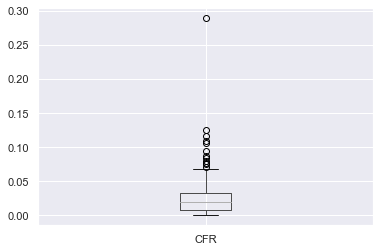

In [14]:
# Explore mortality rates per country
df_new_cfr = df_new.iloc[:,[0,21]]
df_new_cfr = df_new_cfr.sort_values('CFR', axis=0, ascending=False)
print(df_new_cfr)
df_new.boxplot(column = 'CFR')

### Data cleaning

In [15]:
# Remove non number columns for visualization and further data exploration
df_values = df_new.iloc[:, 2:]

In [16]:
# Are there missing values?
missing = df_values.isnull().sum(axis = 0)
perc_miss = (missing/210) *100
print(perc_miss.sort_values(ascending = False))

handwashing_facilities                                               56.666667
extreme_poverty                                                      42.380952
male_smokers                                                         34.285714
female_smokers                                                       33.333333
hospital_beds_per_thousand                                           21.904762
Prevalence of obesity (both sexes) - WHO (2019)                      16.666667
human_development_index                                              15.238095
Daily smoking prevalence                                             15.238095
gdp_per_capita                                                       13.333333
PM2.5 air pollution                                                  12.857143
aged_70_older                                                        12.380952
Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent)    11.904762
cardiovasc_death_rate                               

The variables: handwashing_facilities, extreme_poverty, male_smokers and female_smokers have a missing value rate of over 30%, meaning that no meaningfull data analysis can be done with these variables. 

In [17]:
# Remove variables with over 30 percent missing values
df_values1 = df_values.drop(df_values[['extreme_poverty', 
                                       'handwashing_facilities', 
                                       'male_smokers', 
                                       'female_smokers']], axis=1)
missing1 = df_values1.isnull().sum(axis = 0)
perc_miss1 = (missing1/211) *100
print(perc_miss1.sort_values(ascending = False))

hospital_beds_per_thousand                                           21.800948
Prevalence of obesity (both sexes) - WHO (2019)                      16.587678
Daily smoking prevalence                                             15.165877
human_development_index                                              15.165877
gdp_per_capita                                                       13.270142
PM2.5 air pollution                                                  12.796209
aged_70_older                                                        12.322275
Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent)    11.848341
cardiovasc_death_rate                                                11.848341
median_age                                                           11.848341
diabetes_prevalence                                                   8.530806
population_density                                                    5.687204
life_expectancy                                     

If a country misses data, algorithmic imputing techniques like knn don't portray reality because their is no connection between the alphabetic order of the countries and the variable values. So, we can delete these countries or impute the missing values with zero. 

In [18]:
# Removing rows with  any missing values
df_values2 = df_values1.dropna()
df_values2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 208
Data columns (total 16 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   total_cases_per_million                                            153 non-null    float64
 1   total_deaths_per_million                                           153 non-null    float64
 2   population_density                                                 153 non-null    float64
 3   median_age                                                         153 non-null    float64
 4   aged_70_older                                                      153 non-null    float64
 5   gdp_per_capita                                                     153 non-null    float64
 6   cardiovasc_death_rate                                              153 non-null    float64
 7   diabetes_prevalence       

### Checking data for strange values

In [19]:
# Are there any negative values?
# Only select columns with numbers
df_values2 = df_values2.iloc[:, 2:17]
# Find for each column the number of negative values
df_values2.to_numpy()
np.sum(np.array(df_values2) < 0, axis=0)  

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
# Are there any strange values for each variable?
# display minimum higher than zero
a = np.array(df_values2.min(axis=0))
b = np.array(df_values2.max(axis=0))
c = df_values2.columns
table = zip(c,a,b)
print(tabulate(table, headers= ['column', 'min', 'max'], tablefmt="presto"))

 column                                                            |       min |           max
-------------------------------------------------------------------+-----------+---------------
 population_density                                                |   1.98    |   7915.73
 median_age                                                        |  15.1     |     48.2
 aged_70_older                                                     |   0.526   |     18.493
 gdp_per_capita                                                    | 661.24    | 116936
 cardiovasc_death_rate                                             |  79.37    |    724.417
 diabetes_prevalence                                               |   0.99    |     22.02
 hospital_beds_per_thousand                                        |   0.1     |     13.05
 life_expectancy                                                   |  53.28    |     84.63
 human_development_index                                           |   0.354   |   

## Outlier detection and data visualization

In [21]:
cols = df_values2.columns


np.array(cols)

print(cols)

Index(['population_density', 'median_age', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index',
       'Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent)',
       'PM2.5 air pollution', 'Daily smoking prevalence ',
       'Prevalence of obesity (both sexes) - WHO (2019)', 'CFR'],
      dtype='object')


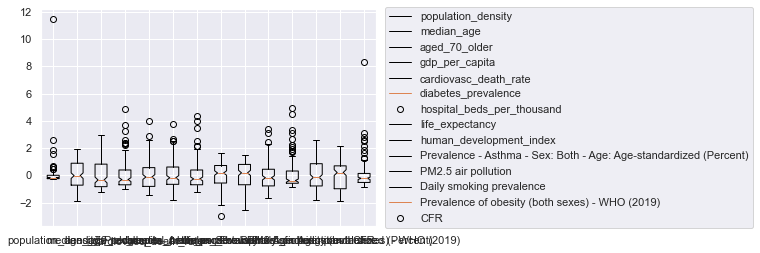

In [22]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_values2)
feat_cols = [str(i) for i in range(df_scaled.shape[1])]
df_norm = pd.DataFrame(df_scaled,columns=feat_cols)# df_scaled = pd.DataFrame(data=df_scaled)
df_norm = df_norm.T
plt.boxplot(df_norm, notch='True', labels=cols)
plt.legend(labels=cols ,loc=6, bbox_to_anchor=(1.01, 0.5))
plt.show()

### PCA

In [23]:
# Label countries with high, medium and low mortality rate
ultra = df_new_cfr.iloc[0:35,1]
very_high = df_new_cfr.iloc[35:70,1]
high = df_new_cfr.iloc[70:105,1]
medium = df_new_cfr.iloc[105:140,1]
medium_low = df_new_cfr.iloc[140:175,1]
low = df_new_cfr.iloc[175:210,1]
# df_new['label'] = df_new['CFR']
df_new['CFR'].replace(ultra, 'u',inplace=True)
df_new['CFR'].replace(very_high, 'v',inplace=True)
df_new['CFR'].replace(high, 'h',inplace=True)
df_new['CFR'].replace(medium, 'm',inplace=True)
df_new['CFR'].replace(medium_low, 'm_l',inplace=True)
df_new['CFR'].replace(low, 'l',inplace=True)
print(df_new['CFR'])

0        v
1        v
2        v
3        v
4        v
      ... 
206      u
207      h
208      v
209      v
210    NaN
Name: CFR, Length: 211, dtype: object


In [24]:
# visualization
df_scaled = StandardScaler().fit_transform(df_values2)
feat_cols = ['feature'+str(i) for i in range(df_scaled.shape[1])]
df_norm = pd.DataFrame(df_scaled,columns=feat_cols)# df_scaled = pd.DataFrame(data=df_scaled)
df_norm.head()
# df_scaled.boxplot()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13
0,-0.226745,-1.454936,-1.054626,-0.916802,2.914831,0.477158,-1.036854,-1.307591,-1.552462,0.700820,0.807696,-0.667112,-1.492640,0.287246
1,-0.151484,0.759700,0.643576,-0.416896,0.437340,0.607768,-0.016689,0.726917,0.385622,-1.307489,-0.616472,0.448812,0.323410,0.064663
2,-0.282053,-0.256293,-0.468879,-0.311390,0.218800,-0.285173,-0.439268,0.476675,0.176282,0.647874,0.050912,-0.757943,0.962391,0.181667
3,0.037939,0.086177,-0.288971,0.067415,-0.516011,1.431405,0.371742,0.497405,0.351857,1.497611,-0.585404,-1.770060,0.009525,0.120309
4,-0.283800,0.063346,0.364184,-0.060419,-0.520064,-0.613029,0.883959,0.445580,0.655738,-0.136480,-0.630821,0.293102,1.063282,-0.219856


In [25]:
# from sklearn.preprocessing import StandardScaler
# features = df_new.columns.tolist()
# target = df_new.loc[:,['location']].values
# df_scaled = StandardScaler().fit_transform(df_values2)

# pc_Df = pd.DataFrame(data = df_scaled
#              , columns = ['principal component 1', 'principal component 2'])

In [26]:
from sklearn.decomposition import PCA
pca_breast = PCA(n_components=2)
pc_df = pca_breast.fit_transform(df_values2)

pc_DF = pd.DataFrame(data = pc_df
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_))

Explained variation per principal component: [0.99893765 0.00103157]


<Figure size 432x288 with 0 Axes>

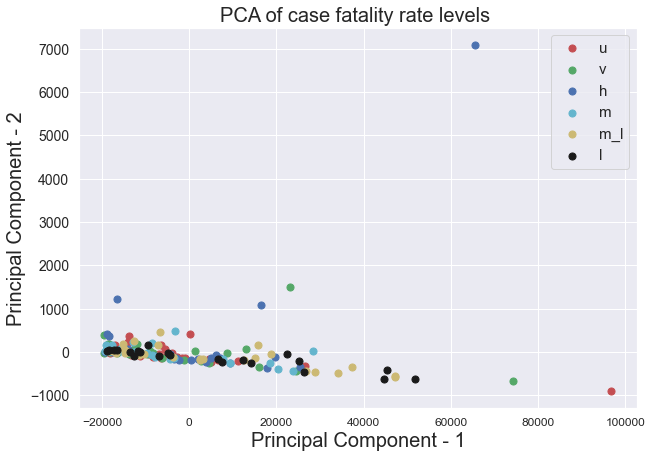

In [27]:
plt.figure()
plt.figure(figsize=(10,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of case fatality rate levels ",fontsize=20)
targets = ['u', 'v', 'h', 'm', 'm_l', 'l']
colors = ['r', 'g', 'b', 'c', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = df_new['CFR'] == target
    plt.scatter(pc_DF.loc[indicesToKeep, 'principal component 1']
               , pc_DF.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})